In [2]:
from keras import backend as K
import keras
from keras import layers
from keras.models import Model
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  #潜在空间维度，一个二维平面

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

In [3]:
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    # K.random_normal返回具有正常值分布的张量。
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


# 可以把任意的一个表达式作为一个“Layer”对象
# Lambda层之所以存在是因为它可以在构建Squential时使用任意的函数或者说tensorflow 函数。
# 在我们需要完成一些简单的操作(例如VAE中的重采样)的情况下，Lambda层再适合不过了。
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [5]:
decoder_input = layers.Input(K.int_shape(z)[1:])
# np.prod计算所有元素的乘积
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 将 z 转换为特征图，使其形状与编码器模型最后一个 Flatten 层之前的特征图的形状相同
x = layers.Reshape(shape_before_flattening[1:])(x)
# 使用一个 Conv2DTranspose 层和一个Conv2D 层，将 z 解码为与原始输入图像具有相同尺寸的特征图
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
# 将解码器模型实例化，它将 decoder_input转换为解码后的图像
z_decoded = decoder(z)

In [6]:
# 用于计算损失的自定义层
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # 通过编写一个call方法来实现自定义层
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 我们不使用这个输出， 但层必须要有返回值
        return x

In [7]:
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
vae = Model(input_img, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 

In [9]:
# loss设置为None
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 222s 4ms/step - loss: 0.2158 - val_loss: 0.1971
Epoch 2/10
60000/60000 [==============================] - 220s 4ms/step - loss: 0.1924 - val_loss: 0.1896
Epoch 3/10
60000/60000 [==============================] - 211s 4ms/step - loss: 0.1877 - val_loss: 0.1858
Epoch 4/10
60000/60000 [==============================] - 208s 3ms/step - loss: 0.1848 - val_loss: 0.1845
Epoch 5/10
60000/60000 [==============================] - 214s 4ms/step - loss: 0.1827 - val_loss: 0.1828
Epoch 6/10
60000/60000 [==============================] - 208s 3ms/step - loss: 0.1812 - val_loss: 0.1817
Epoch 7/10
60000/60000 [==============================] - 212s 4ms/step - loss: 0.1799 - val_loss: 0.1809
Epoch 8/10
60000/60000 [==============================] - 208s 3ms/step - loss: 0.1790 - val_loss: 0.1798
Epoch 9/10
60000/60000 [==============================] - 200s 3ms/step - loss: 0.1781 - val_loss: 0.1

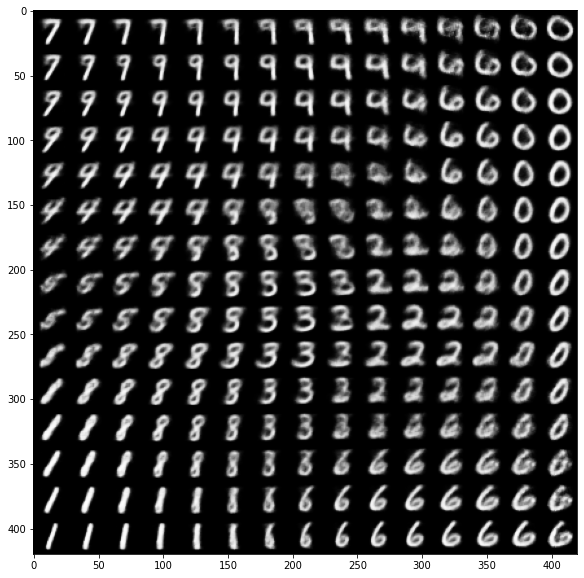

In [10]:
n = 15  # 我们将显示 15×15 的数字网格（共 255 个数字）
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 使用 SciPy 的 ppf 函数对线性分隔的坐标进行变换，
# 以生成潜在变量 z 的值（因 为潜在空间的先验分布是高斯分布）

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        #将 z 多次重复，以构建一个完整的批量
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
#         将批量解码为数字图像
        digit = x_decoded[0].reshape(digit_size, digit_size)
    #将批量第一个数字的 形状从 28×28×1 转 变为 28×28
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()